# Analysing USA Consumer Price Index 

Consumer Price Index for All Urban Consumers (CPI-U) is a common indicator of inflation and rose 0.1 percent in March on a seasonally
adjusted basis, after increasing 0.4 percent in February, the U.S. Bureau of Labor Statistics (reported) [https://www.bls.gov/news.release/cpi.nr0.htm]
today. Over the last 12 months, the all items index increased 5.0 percent before seasonal adjustment.

The all items index increased 5.0 percent for the 12 months ending March; this was the smallest 12-month
increase since the period ending May 2021. The all items less food and energy index rose 5.6 percent
over the last 12 months. The energy index decreased 6.4 percent for the 12 months ending March, and the
food index increased 8.5 percent over the last year.

In this project we access, parse, visualize and analyze the data from the U.S. Bureau of Labor Statistics, and use it to predict the inflation rate uing 
(ARIMA)[] and (Prophet)[].

The Binder file can be found [here](https://hub.gke2.mybinder.org/user/raminvali-time_series_project-fqsvuvso/lab/workspaces/auto-z/tree/ARIMA1.ipynb)

In [1]:
# Wrangling and Data Source Libraries
import os
import json
import requests

# Viz and EDA Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Stats Libraries
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA

# Metrics
from sklearn.metrics import mean_squared_error


# Arch
from arch import arch_model

# Prophet
from prophet import Prophet

c:\Users\Ramin\AppData\Local\Programs\Python\envs\time_series\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Read in the data 
using json from the BLC Public API
Consumer Price Index for All Urban Consumers (CPI-U)
- CUUR0000SA0 unadjusted
- CUSR0000SA0 seasonaly adjusted 
- [link](https://beta.bls.gov/dataQuery/find?fq=survey:[cu]&s=popularity:D)

In [2]:
path = 'all_json_data_season_adjusted'

if os.path.exists(path):
    with open ('all_json_data_season_adjusted','r') as openfile:
        all_json_data_season_adjusted = json.load(openfile)
else:
    
    headers = {'Content-type': 'application/json'}
    
    all_json_data = []
    step = 20 #in years
    for year in range (1950,2025,step):
        parameters = json.dumps({"registrationkey":"YourKeyHere", "seriesid":['CUSR0000SA0'], "startyear":str(year), "endyear":str(year+step), "calculations":"true"})
        response = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data = parameters, headers = headers)

        json_data = json.loads(response.text)
        all_json_data.append(json_data)

    with open ('all_json_data_season_adjusted','w') as outfile:
        json.dump(all_json_data, outfile)

# Parse the json data into a dataframe
We pick from 1983 onwards, as it was the year the inflation rate was re-calibrated by the federal reserve.  

In [3]:
def parse_json(file):    

    data_dict =dict()

    for section in file:
        for part in section['Results']['series']:
            for item in part['data']:
                year = item['year']
                month = item['periodName']
                value = item['value']
                data_dict[month+' '+ year] = value
            
    df = pd.DataFrame(data_dict.items(),columns = ['date','CPI'])
    df['CPI'] = df['CPI'].astype(float)
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    df.sort_index(inplace=True)
    print(df.head())

    return df

In [4]:
df = parse_json(all_json_data_season_adjusted)
df = df[df.index>'01/12/1983'].copy()

              CPI
date             
1950-01-01  23.51
1950-02-01  23.61
1950-03-01  23.64
1950-04-01  23.65
1950-05-01  23.77


# Data Exploration
## First let us decompose the data to check seasonality, ternds and residuals. 

A given time series is thought to consist of three systematic components including level, trend, seasonality, and one non-systematic component called noise.

These components are defined as [follows](https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/):

- Level: The average value in the series.
- Trend: The increasing or decreasing value in the series.
- Seasonality: The repeating short-term cycle in the series.
- Noise: The random variation in the series.

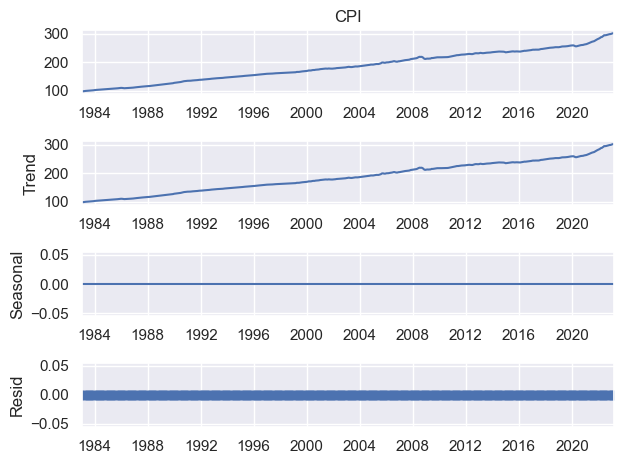

In [5]:
sns.set()
result = seasonal_decompose(df['CPI'], model='additive', period=1)
x = result.plot()

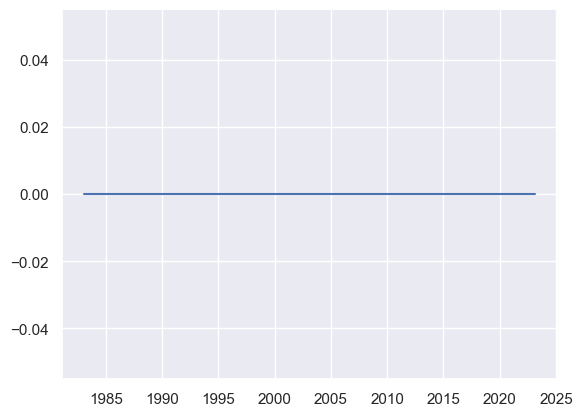

In [6]:
plt.plot(result.resid)

# Visualise and explore the data
Create Plotly figure of data with slider and a figure with percentage change based on values a year ago. 

In [7]:
# Plotly plotting function for time series
def plotly_plot (df, x , y, title, width, height):
    
    # Create figure
    fig = go.Figure()

    fig.add_trace(
        go.Scatter(x=list(x), y=list(y)))

    # Set title
    fig.update_layout(
        title_text=title,
        width=width,
        height=height
    )

    # Add range slider
    fig.update_layout(
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1,
                        label="1m",
                        step="month",
                        stepmode="backward"),
                    dict(count=6,
                        label="6m",
                        step="month",
                        stepmode="backward"),
                    dict(count=1,
                        label="YTD",
                        step="year",
                        stepmode="todate"),
                    dict(count=1,
                        label="1y",
                        step="year",
                        stepmode="backward"),
                    dict(step="all")
                ])
            ),
            rangeslider=dict(
                visible=True
            ),
            type="date"
        )
    )

    fig.show()

In [8]:
plotly_plot(df,df.index, df.CPI, 'Raw Consumer Price Index', 1000, 500)


In [9]:
# Plot percentage
df['pct-change'] =df.CPI.pct_change(periods=12)*100
plotly_plot(df,df.index, df['pct-change'], 'Consumer Price Index Percentage Chnage', 1000, 500)

In [10]:
df['date'] = df.index
df['month'] = df['date'].apply(lambda x: x.month)


fig = px.box(df[12:], x="month", y="pct-change", points = "all",template = "seaborn", )
fig.update_layout(
    xaxis = dict(tickmode = 'linear'),
        title_text="YoY CPI Percentage Change")

# Stationarity

We test the stationarity with a rolling mean and std, Augmented Dicky Fuller and Kwiatkowski-Phillips-Schmidt-Shin (KPSS) tests. 

For the tests, the null hypothesis is that a unit root is present in the time series data. The alternative hypothesis is trend stationarity.

## Data Trends, Rolling Mean, Standard Deviation, Detrending Methods

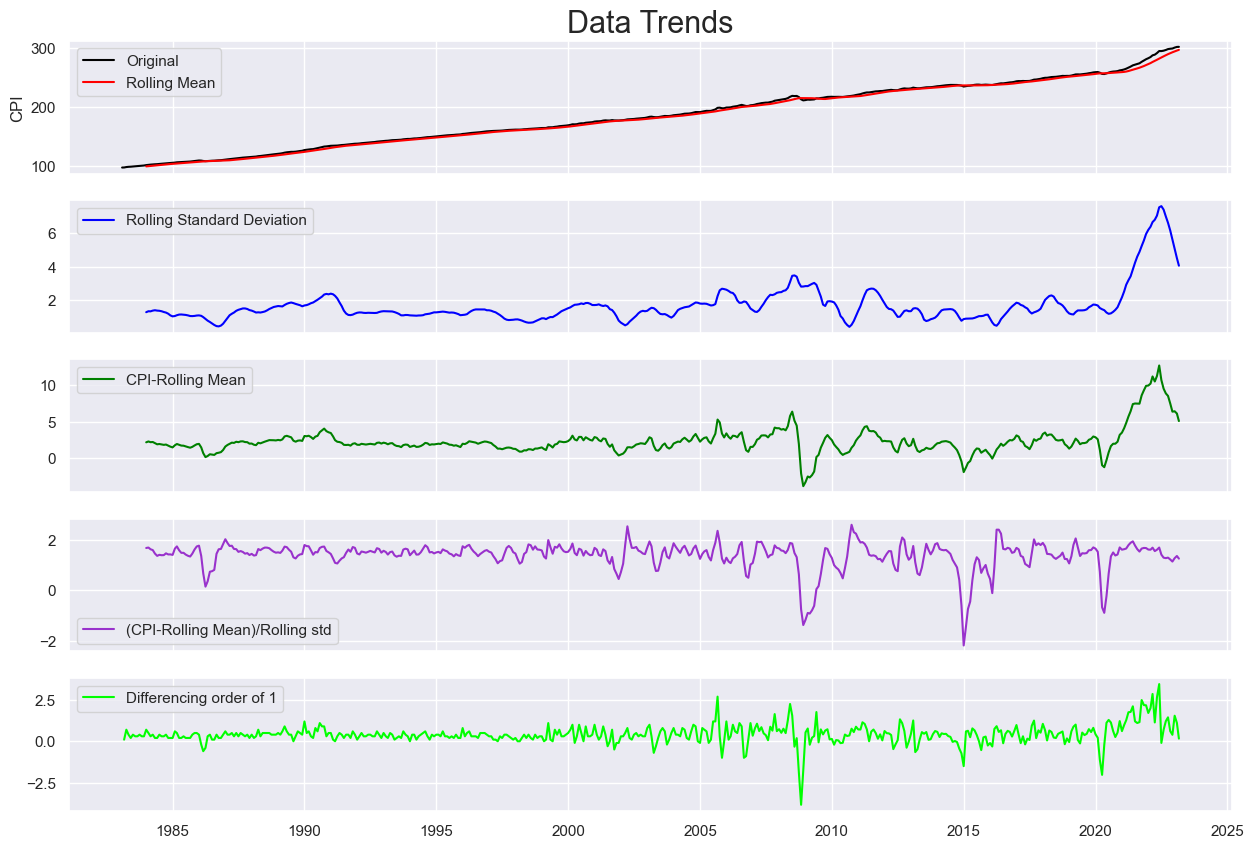

In [11]:
numfig = 5

rmean=df['CPI'].rolling(window=12).mean()
rstd=df['CPI'].rolling(window=12).std()
#print(rmean,rstd)

# First order differencing
diff = df['CPI']-df['CPI'].shift(1)
diff = diff.dropna()
detrend = pd.DataFrame(diff, index = diff.index)


fig, ax = plt.subplots(numfig,1, sharex = True, figsize = (15,10))
ax[0].plot(df['CPI'] , color='black',label='Original')
ax[0].plot(rmean , color='red',label='Rolling Mean')
ax[0].set_ylabel('CPI')

ax[1].plot(rstd,color='blue',label = 'Rolling Standard Deviation')

ax[2].plot(df['CPI']-rmean , color='green',label='CPI-Rolling Mean')

ax[3].plot((df['CPI']-rmean)/rstd , color='darkorchid',label='(CPI-Rolling Mean)/Rolling std')

ax[4].plot(diff , color='lime', label='Differencing order of 1')


for i in range(0,numfig):
 ax[i].legend(loc='best')


ax[0].set_title("Data Trends", fontdict = {'fontsize':22})
plt.show(block=False)

## Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test

In [12]:
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [13]:
kpss_test(df['CPI'])

Results of KPSS Test:
Test Statistic            3.788503
p-value                   0.010000
#Lags Used               12.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


c:\Users\Ramin\AppData\Local\Programs\Python\envs\time_series\Lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




As can be seen, the KPSS indicates the data in non-stationary. 

## Applying the Augmented Dicky-Fuller test   

In [14]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [15]:
adf_test(df['CPI'])

Results of Dickey-Fuller Test:
Test Statistic                   1.415609
p-value                          0.997184
#Lags Used                      15.000000
Number of Observations Used    466.000000
Critical Value (1%)             -3.444461
Critical Value (5%)             -2.867762
Critical Value (10%)            -2.570084
dtype: float64


As the p-value is almost 1, we cannot reject the null hypothesis (that the data is nonstationary).


Based upon the significance level of 0.05 and the p-value of KPSS test, there is not enough evidence for rejecting the null hypothesis in favor of the alternative. Hence, the series is non-stationary as per the KPSS test.

It is always better to apply both the tests, so that it can be ensured that the series is truly stationary. Possible outcomes of applying these stationary tests are as follows:

- Case 1: Both tests conclude that the series is not stationary - The series is not stationary
- Case 2: Both tests conclude that the series is stationary - The series is stationary
- Case 3: KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary. Trend needs to be removed to make series strict stationary. The detrended series is checked for stationarity.
- Case 4: KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.

Here, due to the difference in the results from ADF test and KPSS test, it can be inferred that the series is trend stationary and not strict stationary. The series can be detrended by differencing or by model fitting.

## Correcting for Non-Stationarity
### Approach 1: Detrending by differencing

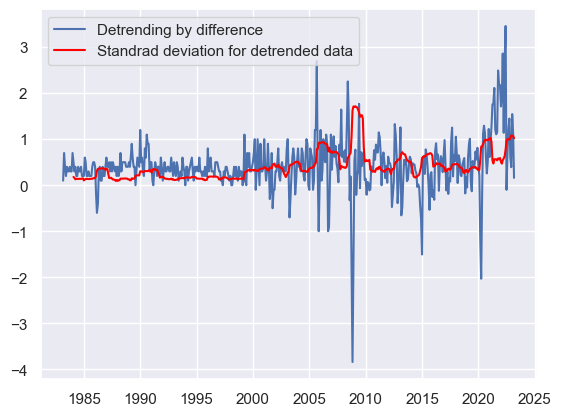

In [16]:
diff = df['CPI']-df['CPI'].shift(1)
diff = diff.dropna()
detrend = pd.DataFrame(diff, index = diff.index).rename(columns={'CPI':'Diff_ord_1'})
plt.plot(detrend, label = 'Detrending by difference')


diff_rstd = detrend.rolling(12).std()
plt.plot(diff_rstd, color = 'red', label = 'Standrad deviation for detrended data')

plt.legend()
plt.show()

In [17]:
detrend['CPI-rolMean'] = (df['CPI']-rmean)
detrend.dropna(inplace=True)

## Comparing ADF and KPSS Test Results for Both Detrending Approaches

In [18]:
print('Results for differencing')
kpss_test(detrend['Diff_ord_1'])
print('\n')
print('Results for rolling mean')
kpss_test(detrend['CPI-rolMean'])

Results for differencing
Results of KPSS Test:
Test Statistic           0.498692
p-value                  0.041961
#Lags Used               9.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


Results for rolling mean
Results of KPSS Test:
Test Statistic            0.459258
p-value                   0.051613
#Lags Used               12.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [19]:
print('Results for differencing')
adf_test(detrend['Diff_ord_1'])
print('\n')
print('Results for rolling mean')
adf_test(detrend['CPI-rolMean'])

Results for differencing
Results of Dickey-Fuller Test:
Test Statistic                  -3.151160
p-value                          0.022992
#Lags Used                      14.000000
Number of Observations Used    456.000000
Critical Value (1%)             -3.444772
Critical Value (5%)             -2.867899
Critical Value (10%)            -2.570157
dtype: float64


Results for rolling mean
Results of Dickey-Fuller Test:
Test Statistic                  -3.101744
p-value                          0.026424
#Lags Used                      15.000000
Number of Observations Used    455.000000
Critical Value (1%)             -3.444804
Critical Value (5%)             -2.867913
Critical Value (10%)            -2.570165
dtype: float64


We have a sufficiently small p-value to reject the null hypothesis and assume that the data is stationary. We choose the *Rolling mean Subtraction* detrending approach based on the ADF and KPSS test values. 

# Checking the Auto-Correlation and Partial Auto-Correlation Functions

c:\Users\Ramin\AppData\Local\Programs\Python\envs\time_series\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



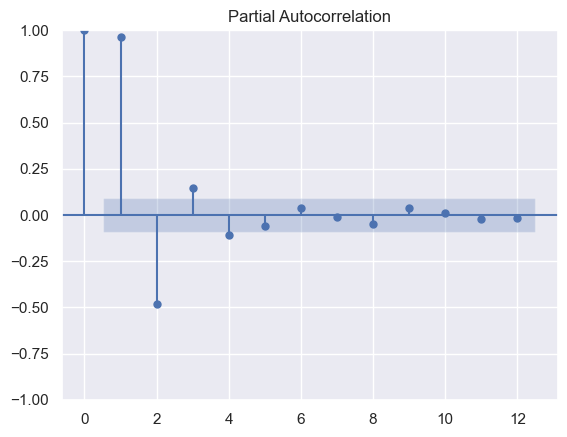

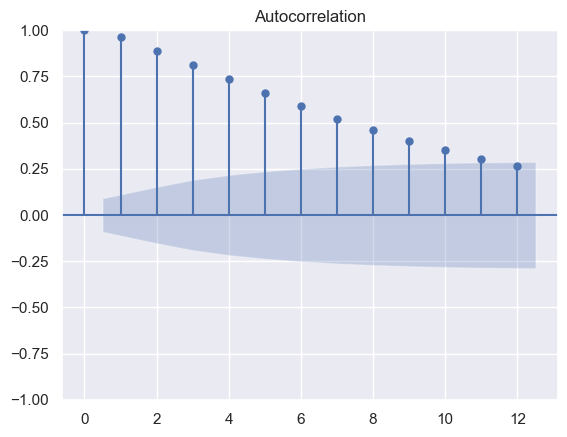

In [20]:
pacf = plot_pacf(detrend['CPI-rolMean'], lags = 12)
acf = plot_acf(detrend['CPI-rolMean'], lags = 12)
# for auto regression we use the PACF, as it only has the direct effects. 

# Aside
Does using a simple log transform make a data stationary? 

In [21]:
kpss_test(np.log(df['CPI']))

Results of KPSS Test:
Test Statistic            3.745887
p-value                   0.010000
#Lags Used               12.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


c:\Users\Ramin\AppData\Local\Programs\Python\envs\time_series\Lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




In [22]:
adf_test(np.log(df['CPI']))

Results of Dickey-Fuller Test:
Test Statistic                  -0.745148
p-value                          0.834706
#Lags Used                      15.000000
Number of Observations Used    466.000000
Critical Value (1%)             -3.444461
Critical Value (5%)             -2.867762
Critical Value (10%)            -2.570084
dtype: float64


*As can be seen form above, doing a log transformation of the CPI data does NOT make it stationary. ONly doing a difference makes it stationary.*

# Train test Split
We use one year as the testing set

Training dataset: 459, Test dataset: 12


<Axes: xlabel='date'>

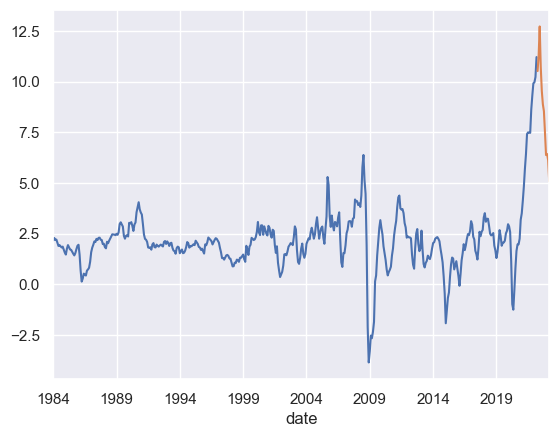

In [23]:
split_point = len(detrend['CPI-rolMean']) - 12
train, test = detrend['CPI-rolMean'][0:split_point], detrend['CPI-rolMean'][split_point:]
print('Training dataset: %d, Test dataset: %d' % (len(train), len(test)))
train.plot()
test.plot()


# Performing ARIMA on Training Data

In [24]:
from pmdarima import auto_arima
stepwise_fit = auto_arima(train, trace=True,
suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=511.101, Time=0.87 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1704.894, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=645.007, Time=0.27 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1196.659, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2199.687, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=509.837, Time=0.44 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=877.651, Time=0.29 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=523.436, Time=0.40 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=511.344, Time=0.76 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=716.261, Time=0.56 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=512.198, Time=0.54 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=512.997, Time=1.29 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=518.446, Time=0.33 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0] intercept
Total fit time: 6.289 seconds


In [25]:
from warnings import filterwarnings
filterwarnings('ignore')

arima_model = ARIMA((train), order = (1,0,2))
arima_fit = arima_model.fit()
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            CPI-rolMean   No. Observations:                  459
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -249.919
Date:                Tue, 02 May 2023   AIC                            509.837
Time:                        18:56:56   BIC                            530.483
Sample:                    01-01-1984   HQIC                           517.968
                         - 03-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3982      0.474      5.061      0.000       1.469       3.327
ar.L1          0.9203      0.017     54.741      0.000       0.887       0.953
ma.L1          0.6215      0.036     17.246      0.000       0.551       0.692
ma.L2          0.2017      0.051      3.973      0.000       0.102       0.301
sigma2         0.1727      0.006     27.092      0.000       0.160       0.185
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1094.61
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               5.71   Skew:                            -0.85
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

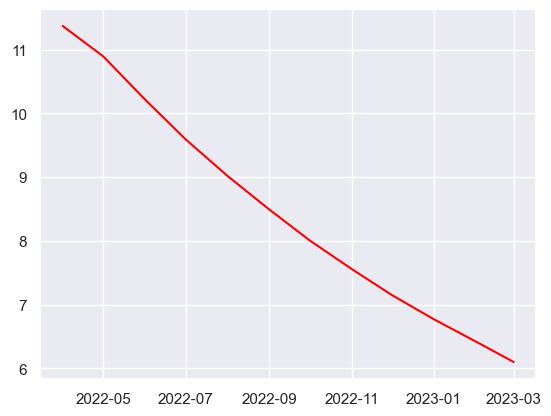

In [26]:
forecast = arima_fit.forecast(steps=12)
plt.plot(forecast, color = 'red')

In [27]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = train.index, y = train, mode = 'lines', name = 'train'))
fig.add_trace(go.Scatter(x = test.index, y = test, mode = 'lines', name = 'test'))
fig.add_trace(go.Scatter(x = forecast.index, y = forecast, mode = 'lines', name = 'forcast'))

fig.update_layout(
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1,
                        label="1m",
                        step="month",
                        stepmode="backward"),
                    dict(count=6,
                        label="6m",
                        step="month",
                        stepmode="backward"),
                    dict(count=1,
                        label="YTD",
                        step="year",
                        stepmode="todate"),
                    dict(count=1,
                        label="1y",
                        step="year",
                        stepmode="backward"),
                    dict(step="all")
                ])
            ),
            rangeslider=dict(
                visible=True
            ),
            type="date"
        )
    )
fig.show()

In [28]:
mse = mean_squared_error(test.values, forecast[:12])
print('MSE: ', mse)
model_error = test - forecast
print('Mean Model Error: ', model_error.mean())

MSE:  0.9119384400093544
Mean Model Error:  0.17692539703241325


In [29]:
rmean

date
1983-02-01           NaN
1983-03-01           NaN
1983-04-01           NaN
1983-05-01           NaN
1983-06-01           NaN
                 ...    
2022-11-01    291.103917
2022-12-01    292.612500
2023-01-01    294.107250
2023-02-01    295.527083
2023-03-01    296.721750
Name: CPI, Length: 482, dtype: float64

# Forecasting for April 2023

In [30]:
forecast # Have to add the rolling mean value to this to make sense on the actal CPI 

2022-04-01    11.370545
2022-05-01    10.893769
2022-06-01    10.216302
2022-07-01     9.592858
2022-08-01     9.019131
2022-09-01     8.491154
2022-10-01     8.005280
2022-11-01     7.558151
2022-12-01     7.146678
2023-01-01     6.768017
2023-02-01     6.419552
2023-03-01     6.098875
Freq: MS, Name: predicted_mean, dtype: float64

In [31]:
arima_model = ARIMA(detrend['CPI-rolMean'], order = (1,0,2),freq=test.index.inferred_freq)

arima_fit = arima_model.fit()

forecast = arima_fit.forecast(steps=1)

print('The Core CPI value for the month April 2023 predicted by ARIMA model is', round(forecast[0]+rmean[-1],2))
print(' This number is the summation of the rolling mean and the forcast from ARIMA which will give us the real prediction')

The Core CPI value for the month April 2023 predicted by ARIMA model is 301.2
 This number is the summation of the rolling mean and the forcast from ARIMA which will give us the real prediction


In [32]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = df['CPI'].index, y = df['CPI'], mode = 'lines', name = 'CPI'))

fig.add_trace(go.Scatter(x = forecast.index, y = [forecast[0]+rmean[-1]], mode = 'markers', name = 'ARIMA forcast'))

fig.update_layout(
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1,
                        label="1m",
                        step="month",
                        stepmode="backward"),
                    dict(count=6,
                        label="6m",
                        step="month",
                        stepmode="backward"),
                    dict(count=1,
                        label="YTD",
                        step="year",
                        stepmode="todate"),
                    dict(count=1,
                        label="1y",
                        step="year",
                        stepmode="backward"),
                    dict(step="all")
                ])
            ),
            rangeslider=dict(
                visible=True
            ),
            type="date"
        )
    )
fig.update_layout(title=dict(text = 'Prediction for April 2023', font = dict(size = 22)))

fig.show()

# GARCH

### generalized autoregressive conditional heteroskedasticity.
Heteroskedasticity describes the irregular pattern of variation of an error term, or variable, in a statistical model. Essentially, where there is heteroskedasticity, observations do not conform to a linear pattern. Instead, they tend to cluster.

The result is that the conclusions and predictive value drawn from the model will not be reliable. GARCH is a statistical model that can be used to analyze a number of different types of financial data, for instance, macroeconomic data. Financial institutions typically use this model to estimate the volatility of returns for stocks, bonds, and market indices. They use the resulting information to determine pricing, judge which assets will potentially provide higher returns, and forecast the returns of current investments to help in their asset allocation, hedging, risk management, and portfolio optimization decisions.

The general process for a GARCH model involves three steps. The first is to estimate a best-fitting autoregressive model. The second is to compute autocorrelations of the error term. The third step is to test for significance.

Two other widely used approaches to estimating and predicting financial volatility are the classic historical volatility (VolSD) method and the exponentially weighted moving average volatility (VolEWMA) method.

In [33]:
# a standard GARCH(1,1) model
garch = arch_model(detrend['CPI-rolMean'], vol='garch', p=1, o=0, q=1)
garch_fitted = garch.fit()

# one-step out-of sample forecast
garch_forecast = garch_fitted.forecast(horizon=1)
predicted_et = garch_forecast.mean['h.1'].iloc[-1]

Iteration:      1,   Func. Count:      6,   Neg. LLF: 647202163432.4307
Iteration:      2,   Func. Count:     15,   Neg. LLF: 326887514.90832186
Iteration:      3,   Func. Count:     21,   Neg. LLF: 3753.2671847983065
Iteration:      4,   Func. Count:     27,   Neg. LLF: 23538.46500388936
Iteration:      5,   Func. Count:     33,   Neg. LLF: 609.3456243383474
Iteration:      6,   Func. Count:     39,   Neg. LLF: 581.3233722371423
Iteration:      7,   Func. Count:     45,   Neg. LLF: 734.8673119956575
Iteration:      8,   Func. Count:     51,   Neg. LLF: 714.3345666090729
Iteration:      9,   Func. Count:     57,   Neg. LLF: 679.239727959221
Iteration:     10,   Func. Count:     63,   Neg. LLF: 640.2427701133998
Iteration:     11,   Func. Count:     69,   Neg. LLF: 619.5913832122005
Iteration:     12,   Func. Count:     75,   Neg. LLF: 520.6014682477769
Iteration:     13,   Func. Count:     80,   Neg. LLF: 581.6051034735918
Iteration:     14,   Func. Count:     86,   Neg. LLF: 1825.3360

In [34]:
total_prediction = predicted_et+rmean[-1]
total_prediction

298.70817042063015

# Combining ARIMA and GARCH



# Prophet


In [35]:
df

,CPI,pct-change,date,month
date,,,,
1983-02-01,98.000,NaN,1983-02-01,2
1983-03-01,98.100,NaN,1983-03-01,3
1983-04-01,98.800,NaN,1983-04-01,4
1983-05-01,99.200,NaN,1983-05-01,5
1983-06-01,99.400,NaN,1983-06-01,6
...,...,...,...,...
2022-11-01,298.598,7.135348,2022-11-01,11
2022-12-01,298.990,6.444940,2022-12-01,12
2023-01-01,300.536,6.347156,2023-01-01,1


In [36]:
df_p = df.copy()
df_p.rename(columns={'date':'ds','CPI':'y'}, inplace=True)
df_p['ds'] = df_p['ds'].astype(str)
#del df2['pct-change']

In [37]:
m = Prophet()
m.fit(df_p)
future = m.make_future_dataframe(periods = 365)
future

18:57:01 - cmdstanpy - INFO - Chain [1] start processing
18:57:01 - cmdstanpy - INFO - Chain [1] done processing


,ds
0,1983-02-01
1,1983-03-01
2,1983-04-01
3,1983-05-01
4,1983-06-01
...,...
842,2024-02-25
843,2024-02-26
844,2024-02-27
845,2024-02-28


In [38]:

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
842,2024-02-25,297.702359,293.072560,301.986251
843,2024-02-26,296.667791,291.923018,301.053023
844,2024-02-27,295.603282,291.620788,300.070983
845,2024-02-28,294.526796,290.305774,299.216099
846,2024-02-29,293.456105,289.256588,297.655858


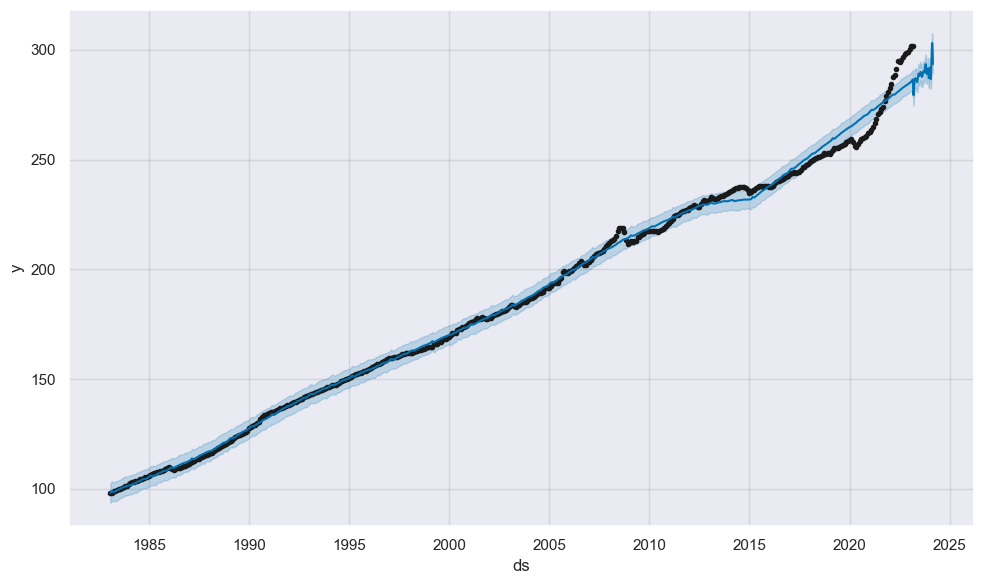

In [39]:
fig1 = m.plot(forecast)


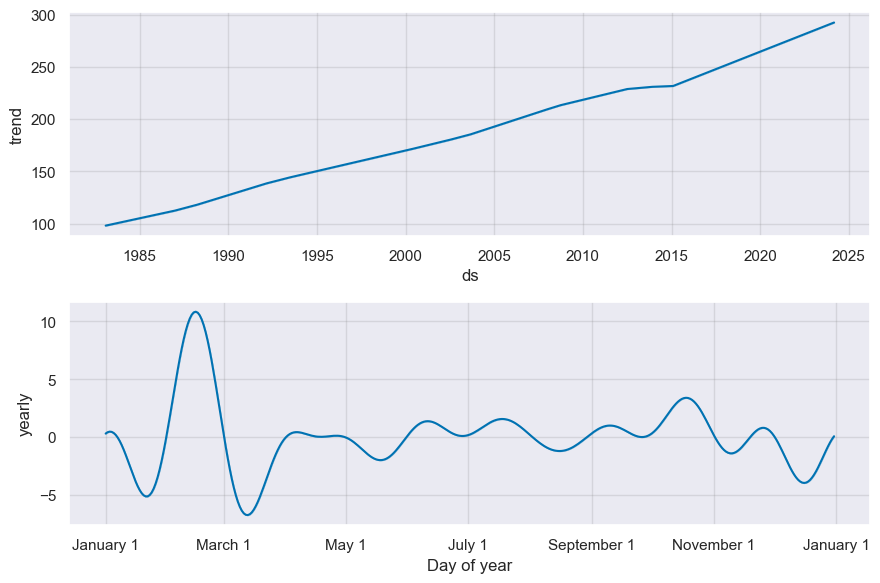

In [40]:
fig2 = m.plot_components(forecast)

In [41]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)


In [42]:
plot_components_plotly(m, forecast)


In [43]:
from scipy.optimize import curve_fit

